# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

## 데이터 읽기

- 특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 불러오기
- 2022-07-11 현재 json 포맷으로 정리되지 않은 정보 존재


In [1]:
import os
import json
from datetime import datetime
import pandas as pd
import numpy as np

#import env

In [2]:
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비')
data_dir = os.path.join(base_dir, '6.sus_45_1circle_process', 'jsonsort')

data_dir

'/home/mygenie/data/AI_DB_CYAUTOTECH/300장비/6.sus_45_1circle_process/jsonsort'

In [3]:
!dir "$data_dir/laseroffset"

0  1  10  11  12  13  14  15  2  3  4  5  6  7	8  9


In [4]:
!dir "$data_dir/sub"

1.txt	11.txt	13.txt	15.txt	2.txt  4.txt  6.txt  8.txt
10.txt	12.txt	14.txt	16.txt	3.txt  5.txt  7.txt  9.txt


In [5]:
sample_id_list = [int(i) for i in os.listdir(os.path.join(data_dir, 'laseroffset'))]
sample_id_list

[9, 13, 14, 5, 12, 8, 6, 0, 7, 11, 2, 15, 1, 4, 3, 10]

In [6]:
%%time

data = {}
for sample_id in sample_id_list:
    
    fname_laser_cond = os.path.join(data_dir, 'laseroffset', str(sample_id), 'laseroffset.txt')
    with open(fname_laser_cond) as f:
        lines = f.readlines()
    
    laser_cond = {k:v for k, v in [s.strip().split(':') for s in lines]}
    
    with open(os.path.join(data_dir, 'sub', f'{sample_id+1}.txt'), encoding='utf-8-sig') as f:
        lines = f.readlines()
        
    prop = {k:v for k, v in [s.strip().split(':') for s in lines]}
    
    data[sample_id] = prop
    data[sample_id].update(laser_cond)

CPU times: user 758 µs, sys: 949 µs, total: 1.71 ms
Wall time: 1.54 ms


In [7]:
data[2]

{'항복강도': '520.1MPa',
 '인장강도': '620.79MPa',
 '연신율': '36.5%',
 '밀도': '7.82',
 'power': '312',
 'speed': '1300'}

## 데이터 전처리

- 빈 칸 없애기, 단위 처리 등
- power 와 speed 가 정순으로 기록


In [8]:
import re
re_num = re.compile(r'([0-9\.]+)(.*)')

In [9]:
# materials = ['SUS']
# facilities = ['Vulcan 300']

data_list = []
for i in range(16):
    _data = data[i]
    
    __data = {}
    for k, v in _data.items():
        if k == 'power':
            __data['laser_power'] = float(v)     ## power 와 speed 가 정배열
        elif k == 'speed':
            __data['laser_speed'] = float(v) ## power 와 speed 가 정배열
        else:
            val, unit = re_num.match(v).groups()
            k = k if len(unit) == 0 else f'{k}({unit})'
            __data[k] = float(val)
    
    data_list.append(__data)

In [10]:
data_list[2]

{'항복강도(MPa)': 520.1,
 '인장강도(MPa)': 620.79,
 '연신율(%)': 36.5,
 '밀도': 7.82,
 'laser_power': 312.0,
 'laser_speed': 1300.0}

In [11]:
df = pd.DataFrame(data_list)
df['laser_density'] = df['laser_power'] / df['laser_speed']

print(data_dir)
df

/home/mygenie/data/AI_DB_CYAUTOTECH/300장비/6.sus_45_1circle_process/jsonsort


,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
0,513.18,566.81,13.5,7.81,264.0,1300.0,0.203077
1,502.20,593.89,38.5,7.82,360.0,1300.0,0.276923
2,520.10,620.79,36.5,7.82,312.0,1300.0,0.240000
3,523.68,614.51,38.5,7.80,408.0,1300.0,0.313846
4,433.80,434.08,7.7,7.82,264.0,1100.0,0.240000
5,537.82,630.19,36.5,7.87,360.0,1100.0,0.327273
6,523.32,625.81,36.5,7.82,312.0,1100.0,0.283636
7,529.46,627.32,38.5,7.78,408.0,1100.0,0.370909
8,552.56,645.28,34.6,7.80,264.0,900.0,0.293333
9,525.29,623.65,38.5,7.86,360.0,900.0,0.400000


# 데이터 분석

In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['font.family'] = 'Malgun Gothic'

def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5)):
    
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x, _y))

## 전체 데이터 분석

In [13]:
_idx = [True] * 16

# _idx[0] = False
# _idx[6] = False
# _idx[7] = False

# _idx[12] = False

df_corr = df.loc[_idx, :].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.858656,0.423573,0.013116,2.134395e-01,-5.483036e-01,0.540887
인장강도(MPa),0.858656,1.000000,0.803206,-0.057894,4.950721e-01,-3.170441e-01,0.526651
연신율(%),0.423573,0.803206,1.000000,-0.065179,6.608427e-01,-3.144731e-02,0.379937
밀도,0.013116,-0.057894,-0.065179,1.000000,-3.748170e-01,-3.123475e-02,-0.239705
laser_power,0.213440,0.495072,0.660843,-0.374817,1.000000e+00,1.894781e-17,0.557257
laser_speed,-0.548304,-0.317044,-0.031447,-0.031235,1.894781e-17,1.000000e+00,-0.806439
laser_density,0.540887,0.526651,0.379937,-0.239705,5.572572e-01,-8.064392e-01,1.000000


### 공정변수 vs 기계적 특성치 분포

In [14]:
y_cols = df.columns[:4].tolist()
df_plot = df.loc[_idx, :]

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.

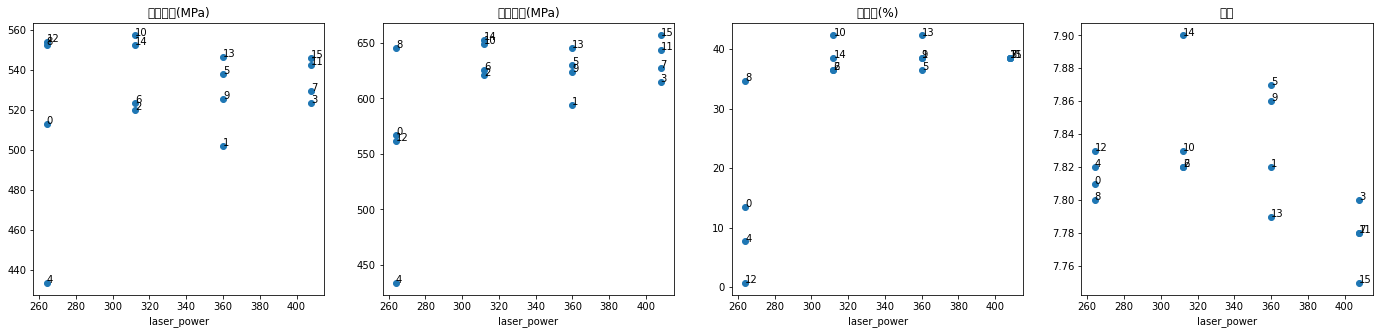

In [15]:
plot_annot(df_plot, 'laser_power', y_cols)

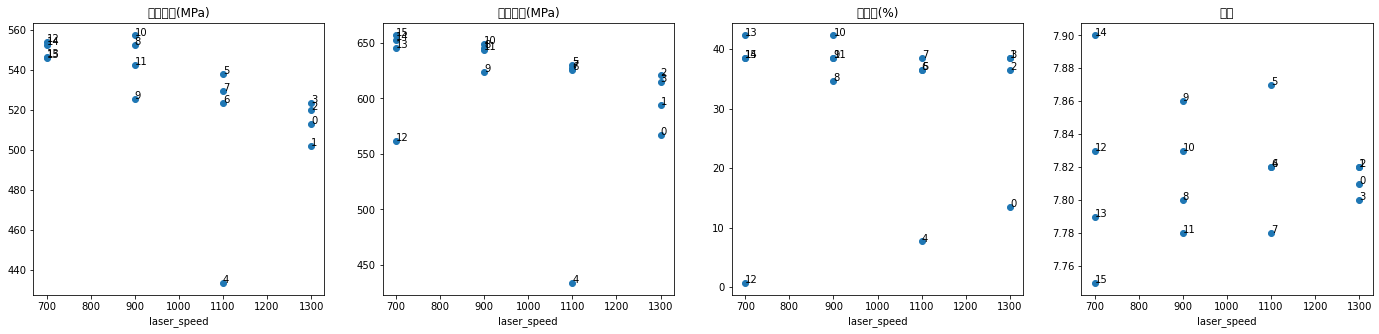

In [16]:
plot_annot(df_plot, 'laser_speed', y_cols)

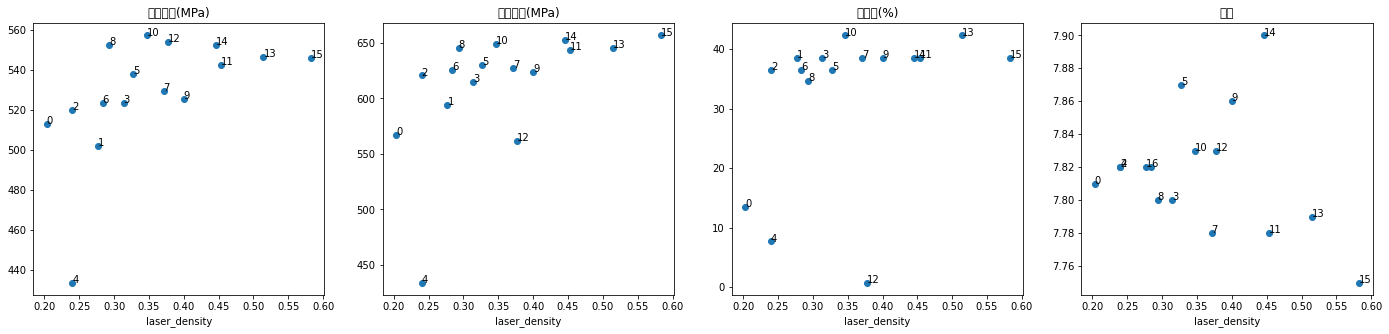

In [17]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

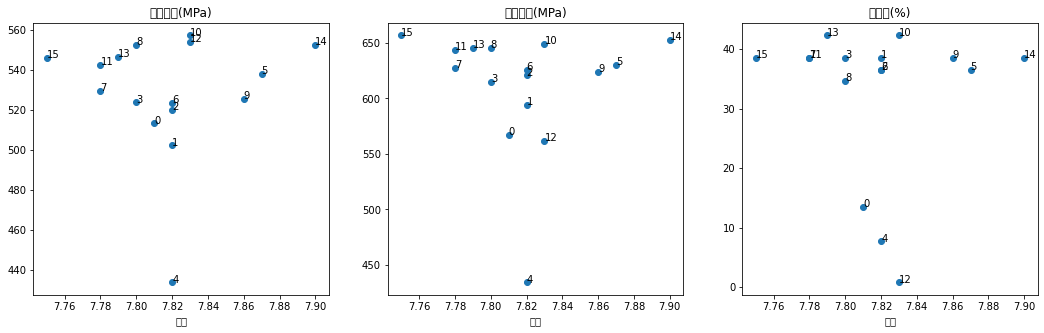

In [18]:
y_cols = df.columns[:3].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))

## 이상치 제외 데이터 분석 (0, 4, 12 번 제외)

In [19]:
_idx = [True] * 16

_idx[0] = False
_idx[4] = False
_idx[12] = False

df_corr = df.loc[_idx, :].corr()
df_corr

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.946856,0.258829,0.009248,-0.243334,-0.799232,0.520811
인장강도(MPa),0.946856,1.000000,0.225517,-0.100290,-0.144812,-0.874659,0.671877
연신율(%),0.258829,0.225517,1.000000,-0.098888,0.299662,-0.368739,0.488492
밀도,0.009248,-0.100290,-0.098888,1.000000,-0.464465,0.015226,-0.297835
laser_power,-0.243334,-0.144812,0.299662,-0.464465,1.000000,0.069171,0.468568
laser_speed,-0.799232,-0.874659,-0.368739,0.015226,0.069171,1.000000,-0.827599
laser_density,0.520811,0.671877,0.488492,-0.297835,0.468568,-0.827599,1.000000


### 공정변수 vs 기계적 특성치 분포

In [20]:
y_cols = df.columns[:4].tolist()
df_plot = df.loc[_idx, :]

/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from curren

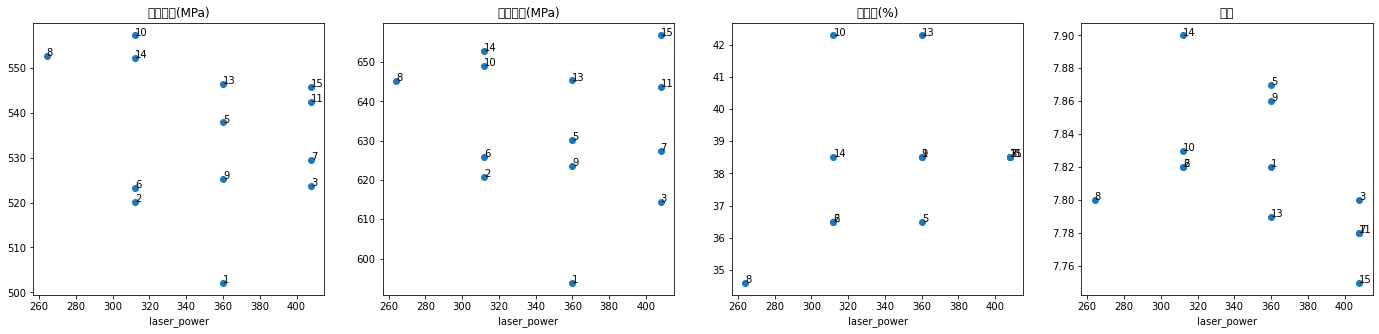

In [21]:
plot_annot(df_plot, 'laser_power', y_cols)

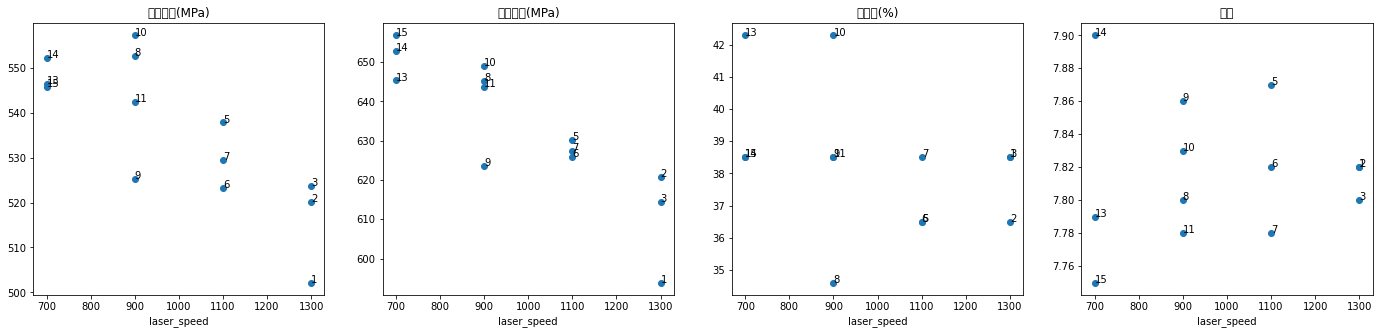

In [22]:
plot_annot(df_plot, 'laser_speed', y_cols)

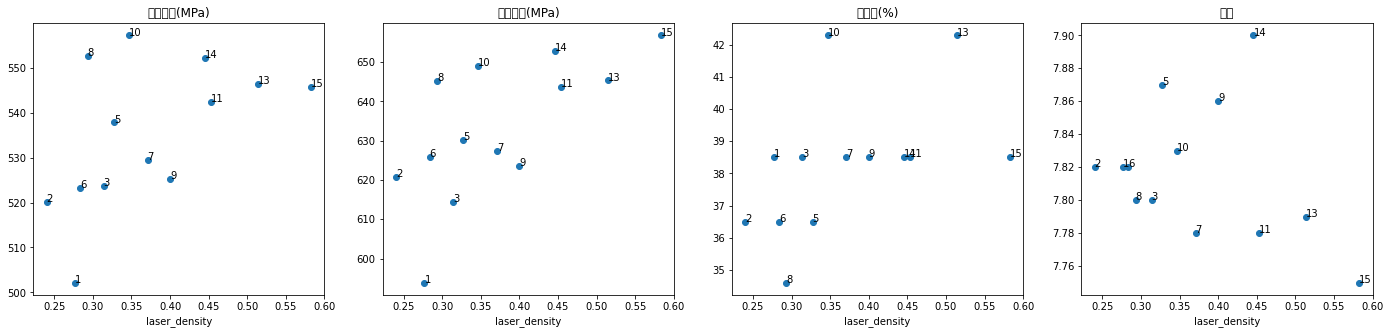

In [23]:
plot_annot(df_plot, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

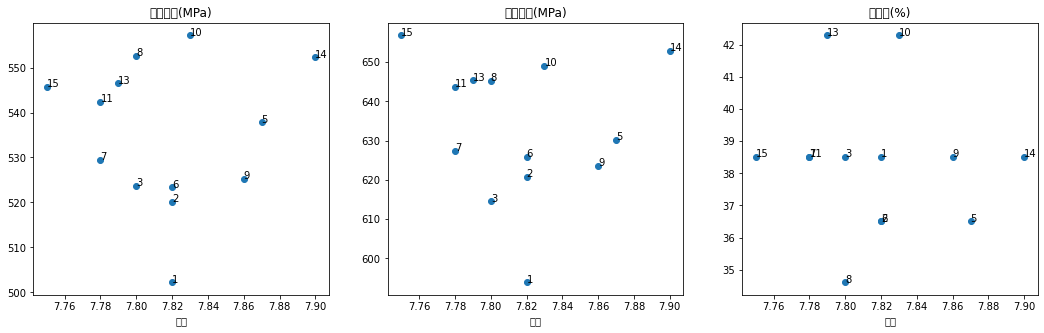

In [24]:
y_cols = df.columns[:3].tolist()

plot_annot(df_plot, '밀도', y_cols, figsize=(18, 5))